In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from ALLCools.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scipy.cluster.hierarchy as sch

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


## Load data

- Use L1 PC centroids to calculate major type PC


In [2]:
cell_tidy_data = pd.read_msgpack('/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
level1_adata = anndata.read_h5ad('/home/hanliu/project/mouse_rostral_brain/study/Level1-CellClass/ALL_manual/Coords/adata.with_pc_and_coords.h5ad')              

In [4]:
cell_pc_df = pd.DataFrame(level1_adata.obsm['X_pca'], 
                          index=level1_adata.obs_names, 
                          columns=[f'PC{i}' for i in range(level1_adata.obsm['X_pca'].shape[1])])

n_pcs = cell_pc_df.shape[1]

## Calc dendrogram

In [5]:
cluster_col = 'MajorType'

In [6]:
use_cell = cell_pc_df.index & cell_tidy_data.index
use_cell.size

103982

In [7]:
cell_pc_df = cell_pc_df.reindex(use_cell)
cell_tidy_data = cell_tidy_data.reindex(use_cell)
type_pc_centroids = cell_pc_df.groupby(cell_tidy_data[cluster_col]).median()

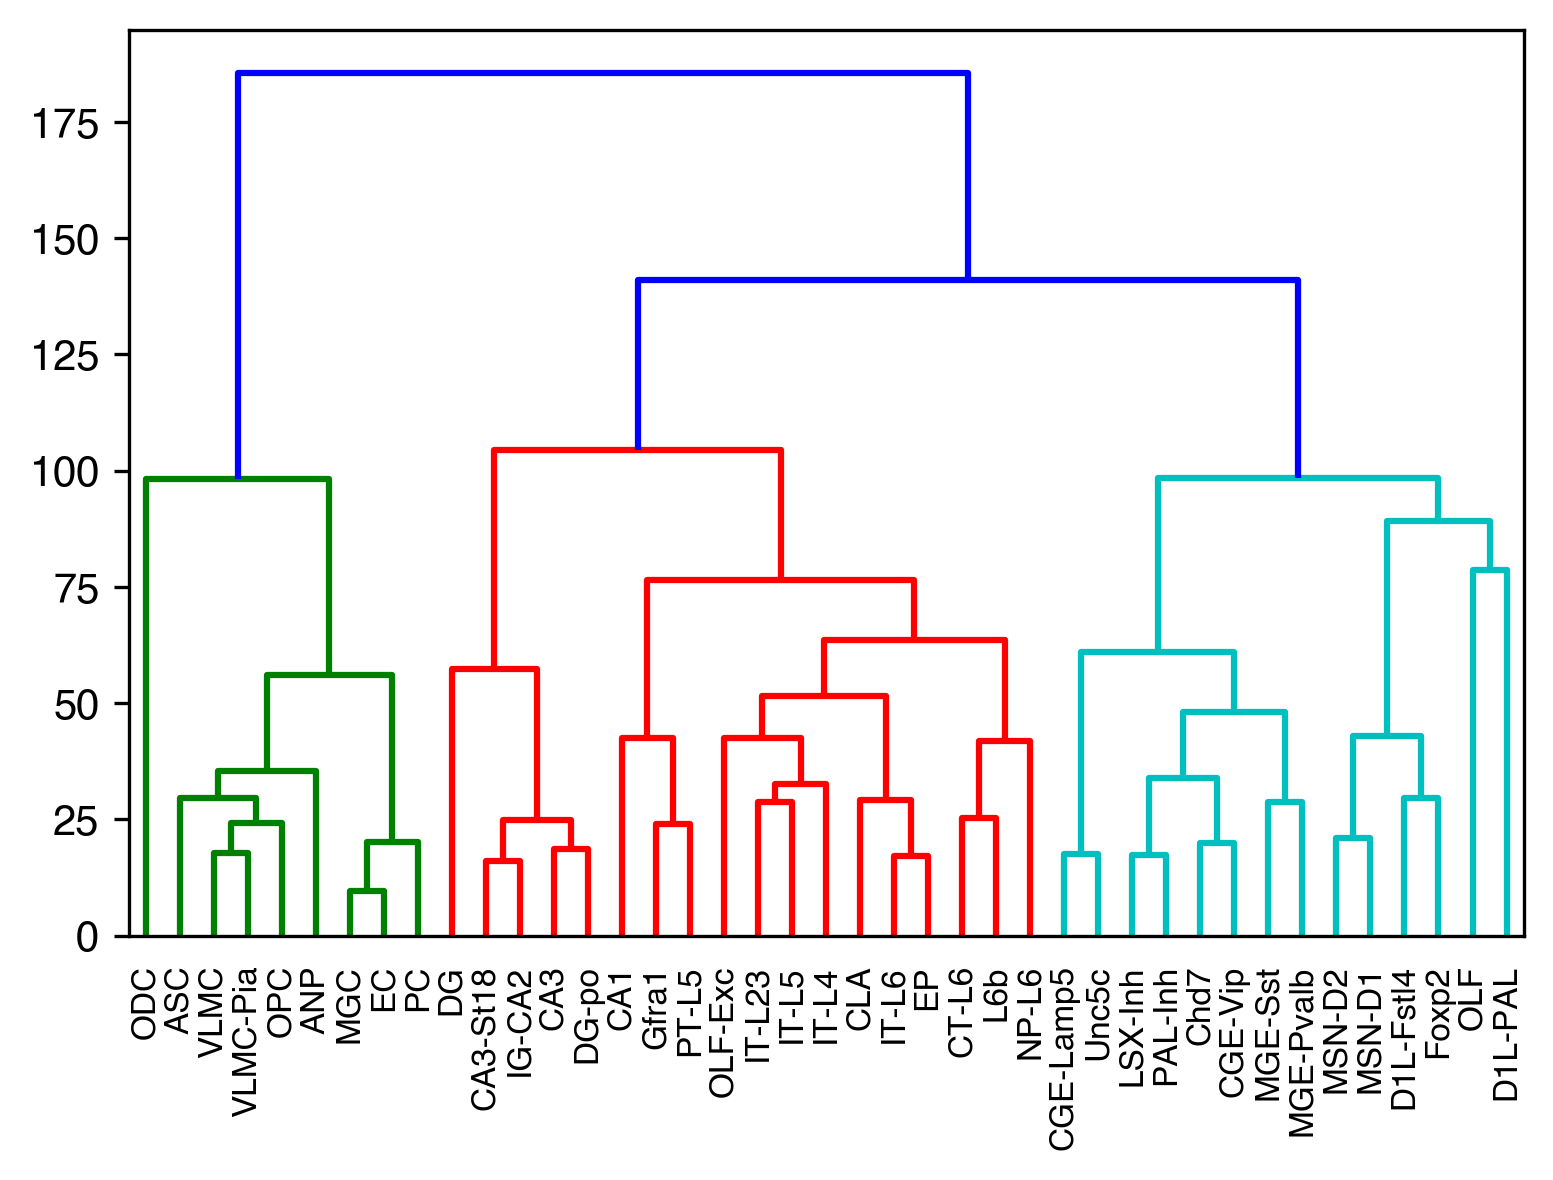

In [9]:
linkage = sch.linkage(type_pc_centroids,
                      method='ward',
                      metric='euclidean',
                      optimal_ordering=True)

fig, ax = plt.subplots(dpi=300)

dendro_info = sch.dendrogram(linkage,
                             labels=type_pc_centroids.index,
                             no_plot=False,
                             ax=ax)

with open(f'files/{cluster_col}.order_by_dendrogram.txt', 'w') as f:
    f.write('\n'.join(dendro_info['ivl']))

ax.xaxis.set_tick_params(rotation=90)

linkage_df = pd.DataFrame(linkage)
linkage_df.to_csv(f'files/{cluster_col}.use_level1_pc.cluster_center.linkage_table.csv',
                             header=None,
                             index=None)

linkage_anno = pd.Series(type_pc_centroids.index.tolist())
linkage_anno.to_csv(f'files/{cluster_col}.use_level1_pc.cluster_center.anno.csv', header=False)

import json
with open(f'files/{cluster_col}.dendrogram_info.json', 'w') as f:
    json.dump(dendro_info, f)